In [1]:
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model

from sklearn.metrics import roc_curve,roc_auc_score

from datetime import datetime,timedelta

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,0],vmin=0, vmax=1,cmap='Greys')
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))

In [3]:
model_path = './15 - 3x_vs3ximproved_simple_weights/'

### Generation des images


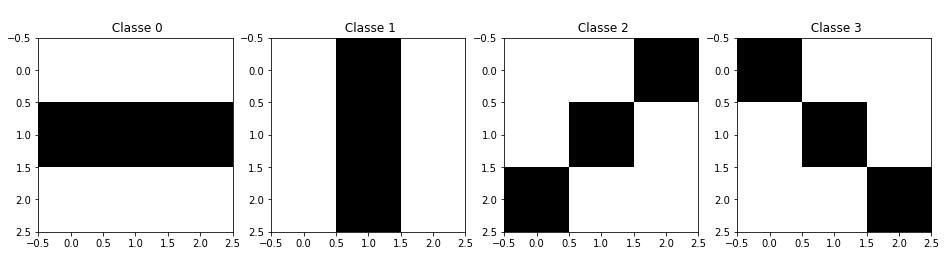

In [4]:
#Generation des 4 images de base => (4,3,3,1)
basepicture =np.zeros((4,3,3,1))
for m in range(4):
    if (m==0):
        #Horizontale        
        for j in range(3):
            basepicture[m,1,j,0] = 1
    if (m==1):
        #Vertical
        for j in range(3):
            basepicture[m,j,1,0] = 1
    if (m==2):
        #Diag
        for j in range(3):
            basepicture[m,2-j,j,0] = 1
    if (m==3):
        #Backslash
        for j in range(3):
            basepicture[m,j,j,0] = 1

basepictureH = basepicture[0,:,:,0]
basepictureV = basepicture[1,:,:,0]
basepictureD = basepicture[2,:,:,0]
basepictureB = basepicture[3,:,:,0]
fig=plt.figure(figsize=(16,16))
template=('\n Classe {}')
for classe in range(4):
    subplot = fig.add_subplot(1,4,classe+1)
    plt.imshow(basepicture[classe,:,:,0],vmin=0, vmax=1,cmap='Greys')
    subplot.title.set_text((template.format(classe)))





## Generation dataset

In [5]:
nb_classes = 4
img_rows, img_cols = 3, 3
input_shape = (img_rows, img_cols, 1)

def buildDataSet(basepicture, nb_image_per_class=1, noise_amplitude=0.2):
    """Generation d'image en rajoutant du bruit sur les images de base
    
    
    returns:
        dataset : tableau (N) contenant les images pour chacune des classes (nb_image_per_class,3,3,1)
    """
    N,w,h,c = basepicture.shape
    
    SplitTrainTest = 0.7
    nb_train_sample = int(nb_image_per_class*SplitTrainTest)
    nb_test_sample = nb_image_per_class-nb_train_sample
    
    dataset_train = [np.zeros((nb_train_sample,h, w,c)) for i in range(N)]
    dataset_test = [np.zeros((nb_test_sample,h, w,c)) for i in range(N)]
    
    for n in range(N):
        #Genere la matrice de bruit pour toutes les images
        dataset_train[n] = np.random.uniform(0,noise_amplitude,(nb_train_sample,w,h,c))
        dataset_test[n] = np.random.uniform(0,noise_amplitude,(nb_test_sample,w,h,c))
        
        #Ajoute l'image de base au bruit existant
        for x in range(nb_train_sample):
            dataset_train[n][x,:,:,0] += basepicture[n,:,:,0]
            
        for x in range(nb_test_sample):
            dataset_test[n][x,:,:,0] += basepicture[n,:,:,0]
            
        #Clip les valeurs en dehors de 0 1
        dataset_train[n] = np.clip(dataset_train[n],0,1)
        dataset_test[n] = np.clip(dataset_test[n],0,1)
        
    return dataset_train,dataset_test

(700, 3, 3, 1)
(300, 3, 3, 1)
dataset train : 4x (700, 3, 3, 1)
dataset test : 4x (300, 3, 3, 1)


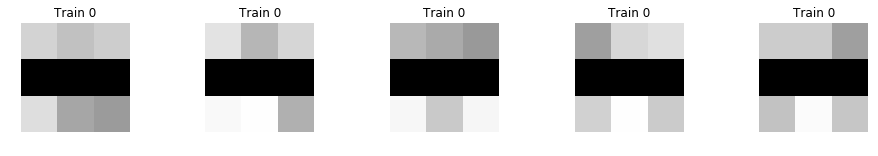

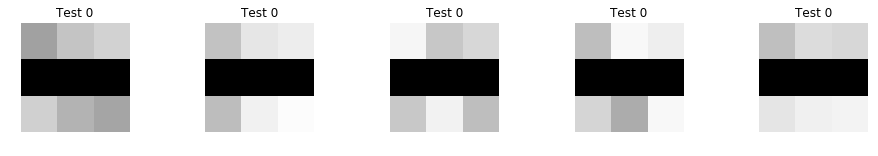

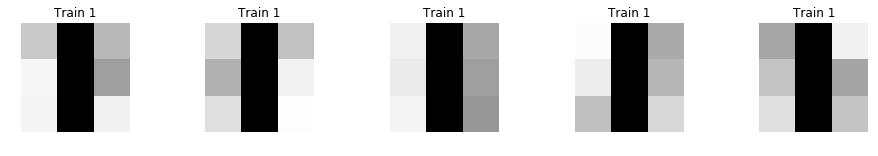

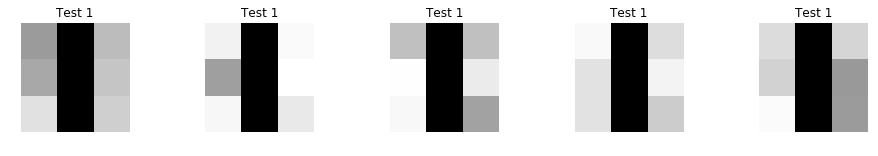

In [6]:
dataset_train,dataset_test = buildDataSet(basepicture, nb_image_per_class=1000, noise_amplitude=0.5)
dataset_test_flat_X = np.concatenate((dataset_test[0],dataset_test[1],dataset_test[2],dataset_test[3]),axis=0)
dataset_test_flat_Y = np.concatenate((np.ones((dataset_test[0].shape[0]))*0,np.ones((dataset_test[0].shape[0]))*1,np.ones((dataset_test[0].shape[0]))*2,np.ones((dataset_test[0].shape[0]))*3),axis=0)
print(dataset_train[0].shape)
print(dataset_test[0].shape)
print("dataset train : 4x",dataset_train[0].shape)
print("dataset test : 4x",dataset_test[0].shape)
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)


### Definition du modele de similarité

In [14]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential(name="featuremap_embedding")
    network.add(Conv2D(4, (3,3), activation='relu',padding='same',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    
    
    return network

In [15]:
def build_metric_network(single_embedding_shape):
    '''
    Define the neural network to learn the metric
    Input : 
            single_embedding_shape : shape of input embeddings or feature map. Must be an array
            
    '''
    #compute shape for input
    input_shape = single_embedding_shape
    #the two input embeddings will be concatenated    
    input_shape[0] = input_shape[0]*2
    
     # Neural Network
    network = Sequential(name="learned_metric")
    network.add(Dense(4, activation='relu',
                   input_shape=input_shape, 
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    network.add(Dense(4, activation='relu',                   
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))    
    
    #Last layer : binary softmax
    network.add(Dense(2, activation='softmax'))
    
    #Select only one output value from the softmax
    network.add(Lambda(lambda x: x[:,0]))
    
    return network

class TripletLossImprovedLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossImprovedLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        ap_dist,an_dist = inputs

        #Loss function formula 
        return K.sum(K.maximum(K.square(ap_dist) - K.square(an_dist) + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
def build_model3improved(input_shape, network, metricnetwork,margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            metricnetwork : Neural network to train the learned metric
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the four input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #compute the concatenated pairs
    encoded_ap = Concatenate(axis=-1,name="Anchor-Positive")([encoded_a,encoded_p])
    encoded_an = Concatenate(axis=-1,name="Anchor-Negative")([encoded_a,encoded_n])
    
    #compute the distances AP and AN 
    ap_dist = metricnetwork(encoded_ap)
    an_dist = metricnetwork(encoded_an)
    
    
    #TripletLoss Layer improved
    loss_layer = TripletLossImprovedLayer(alpha=margin,name='3xLoss')([ap_dist,an_dist])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

In [36]:
#modele en 3xloss improved
network3i = build_network(input_shape,embeddingsize=2)
metric_network3i = build_metric_network(single_embedding_shape=[36])
network3i_train = build_model3improved(input_shape,network3i,metric_network3i)
optimizer3i = Adam(lr = 0.00006)
network3i_train.compile(loss=None,optimizer=optimizer3i)
network3i_train.summary()
plot_model(network3i_train,show_shapes=True, show_layer_names=True, to_file='15 model3i.png')

n_iteration=0
#network_train.load_weights('mnist-160k_weights.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
featuremap_embedding (Sequentia (None, 36)           40          anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

![alt text](15 model3i.png " ")

In [37]:
#testing our NN with dummy image
featured_img = network3i.predict(np.ones((1,img_rows,img_cols,1)))
print(featured_img)

[[0.43327093 0.         0.         0.5443953  0.04996634 0.
  0.         1.0674641  0.46158278 0.         0.         1.0700692
  0.4697678  0.         0.         0.         0.7965549  0.
  0.         0.3579502  0.71181834 0.         0.         0.41272026
  0.847155   0.         0.         0.82140905 1.7655511  0.
  0.         0.39074218 1.1267946  0.         0.         0.        ]]


In [12]:
print("weights 3i",network3i.layers[0].get_weights(),network3i.layers[1].get_weights())

weights 3i [array([[[[-0.49356   ,  0.14314657, -0.34557456, -0.01238573]],

        [[-0.13116086,  0.48523593, -0.1321733 , -0.21477014]],

        [[-0.1183396 , -0.23373139,  0.55881906,  0.44759285]]],


       [[[-0.6783285 ,  0.10400742,  0.5809355 ,  0.20077622]],

        [[-0.20667899,  0.3959204 , -0.32617414, -0.71449625]],

        [[-0.4377481 , -0.63955903,  0.29806483,  0.2300458 ]]],


       [[[ 0.41198087, -0.19607288,  0.01897973,  0.74784076]],

        [[-0.26341224,  0.33894265,  0.5593319 ,  0.25829053]],

        [[-0.05741787,  0.80541456,  0.32618856, -0.66494954]]]],
      dtype=float32), array([0., 0., 0., 0.], dtype=float32)] []


In [13]:
print(metric_network3i.layers[0].get_weights()[0],metric_network3i.layers[1].get_weights()[0])

[[ 0.05157161 -0.14523566 -0.36217612 -0.6454931 ]
 [-1.0269912  -0.7316909   0.7301389  -1.1500129 ]
 [-1.1615455  -0.14480877 -0.12920558 -0.90551996]
 [ 0.8860899  -0.06586218 -0.4007064  -0.17937624]] [[ 0.21824515 -0.96434253  0.753111    0.90581834]
 [-0.5274977  -0.01349807  0.6520803   0.6166123 ]
 [ 1.1626235  -0.8897258  -0.94967324 -0.77533525]
 [ 1.0274087   0.21355188  1.1850497  -0.7663319 ]]


In [14]:
print(metric_network3i.predict(np.reshape([0, 1,0,1],(1,4))))

[0.47163102]


### Preparing batch for training


In [26]:
def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 

    Returns:
    triplets -- array containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    n_classes = len(dataset_train)
    
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, n_classes) 
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(n_classes,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,n_classes)) % n_classes
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, m)

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        triplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]

    return triplets

def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(labels[i])

Batch width 3
Shapes in the batch A:(2, 3, 3, 1) P:(2, 3, 3, 1) N:(2, 3, 3, 1)


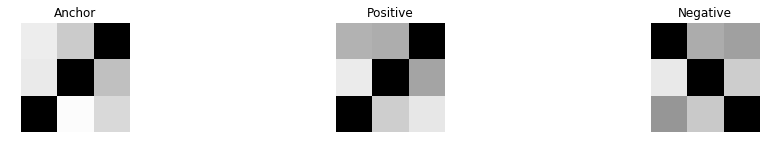

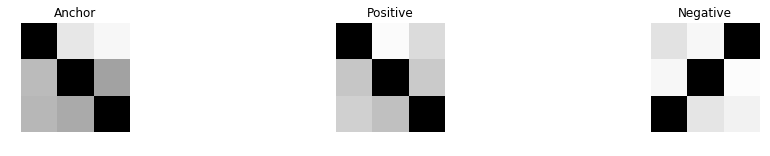

In [27]:
triplets = get_batch_random(2)
print("Batch width",len(triplets))
print("Shapes in the batch A:{0} P:{1} N:{2}".format(triplets[0].shape, triplets[1].shape, triplets[2].shape))
drawTriplets(triplets)

### Validation / evaluation



In [40]:
def compute_l2_dist(a,b):
    return np.sum(np.square(a-b))

def compute_learned_dist(a,b,metricnetwork):
    c = np.concatenate((a,b), axis=-1)
    d = np.reshape(c,(1,c.shape[0]))
    return metricnetwork.predict(d)



In [33]:
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_l2_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y

def compute_probs3i(network,metricnetwork,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_learned_dist(embeddings[i,:],embeddings[j,:],metricnetwork)
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y


def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,img_rows,img_cols,1))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))

    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds,auc,n_iteration):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f} @ {4} iterations\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold),n_iteration ))
    # show the plot
    plt.show()
    
 
def draw_eval(network,n_iteration):
    probs,yprob = compute_probs(network, metricnetwork,dataset_test_flat_X,dataset_test_flat_Y)
    fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr,thresholds,auc,n_iteration)
    draw_interdist(network,n_iteration)
    
def draw_eval3i(network,metricnetwork,n_iteration):
    probs,yprob = compute_probs3i(network, metricnetwork,dataset_test_flat_X,dataset_test_flat_Y)
    fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr,thresholds,auc,n_iteration)
    draw_embeddings(network)
    draw_interdist(network,n_iteration)

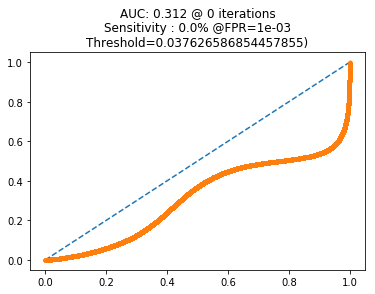

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:109: MatplotlibDeprecationWarning: numpy.hypot


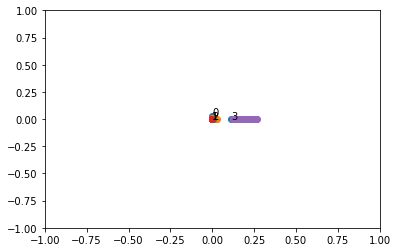

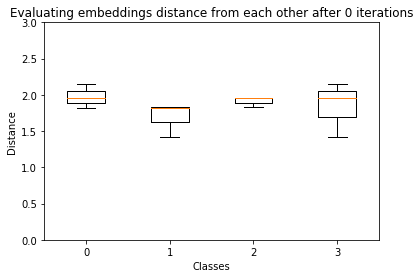

In [41]:
#Testing on an untrained network
draw_eval3i(network3i,metric_network3i,n_iteration)

In [23]:
def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_l2_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1
            
def DrawTestImageLearnedMetric(network, metricnetwork, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_learned_dist(image_embedings[i,:],ref_embedings[ref,:],metricnetwork)
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1}".format(ref,dist[0])))
            plotidx += 1

In [ ]:
for i in range(3):
    DrawTestImageLearnedMetric(network3i,metric_network3i,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))
    

### Training

In [33]:
# Hyper parameters
evaluate_every = 1000 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 100000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on

In [37]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    triplets = get_batch_random(batch_size)
    loss1 = 0#network3_train.train_on_batch(triplets, None)
    loss2 = network3i_train.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        #print("\n ------------- \n")
        elapsed_minutes = (time.time()-t_start)/60.0
        rate = i/elapsed_minutes 
        eta = datetime.now()+timedelta(minutes=(n_iter-i)/rate)
        eta = eta + timedelta(hours=1) #french time
        print("[{4}] iteration {0}: {1:.1f} iter/min, Train Loss: {2} {3}, eta : {5}".format(i, rate,loss1,loss2,n_iteration,eta.strftime("%Y-%m-%d %H:%M:%S") ))
        #network3_train.save_weights('{1}3x-temp_weights_{0}.h5'.format(n_iteration,model_path))
        network3i_train.save_weights('{1}3ix-temp_weights_{0}.h5'.format(n_iteration,model_path))        
        #probs,yprob = compute_probs(network3,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr)
print("Done !")

Starting training process!
-------------------------------------
[141000] iteration 1000: 9504.3 iter/min, Train Loss: 0 0.024577654898166656, eta : 2020-03-10 15:59:45
[142000] iteration 2000: 6940.3 iter/min, Train Loss: 0 0.024535130709409714, eta : 2020-03-10 16:03:38
[143000] iteration 3000: 6523.6 iter/min, Train Loss: 0 0.024480652064085007, eta : 2020-03-10 16:04:33
[144000] iteration 4000: 6346.0 iter/min, Train Loss: 0 0.024434486404061317, eta : 2020-03-10 16:04:59
[145000] iteration 5000: 6236.7 iter/min, Train Loss: 0 0.024376865476369858, eta : 2020-03-10 16:05:15
[146000] iteration 6000: 6148.4 iter/min, Train Loss: 0 0.024316955357789993, eta : 2020-03-10 16:05:29
[147000] iteration 7000: 6094.8 iter/min, Train Loss: 0 0.024272117763757706, eta : 2020-03-10 16:05:38
[148000] iteration 8000: 6053.7 iter/min, Train Loss: 0 0.024234026670455933, eta : 2020-03-10 16:05:44
[149000] iteration 9000: 6023.4 iter/min, Train Loss: 0 0.4242004156112671, eta : 2020-03-10 16:05:49
[

[219000] iteration 79000: 5608.5 iter/min, Train Loss: 0 0.021207725629210472, eta : 2020-03-10 16:07:03
[220000] iteration 80000: 5610.7 iter/min, Train Loss: 0 0.18906663358211517, eta : 2020-03-10 16:07:03
[221000] iteration 81000: 5613.7 iter/min, Train Loss: 0 0.021151799708604813, eta : 2020-03-10 16:07:02
[222000] iteration 82000: 5616.1 iter/min, Train Loss: 0 0.02110597863793373, eta : 2020-03-10 16:07:02
[223000] iteration 83000: 5618.3 iter/min, Train Loss: 0 0.02107587456703186, eta : 2020-03-10 16:07:01
[224000] iteration 84000: 4619.6 iter/min, Train Loss: 0 0.021021127700805664, eta : 2020-03-10 16:10:52
[225000] iteration 85000: 4630.9 iter/min, Train Loss: 0 0.020992379635572433, eta : 2020-03-10 16:10:49
[226000] iteration 86000: 4641.8 iter/min, Train Loss: 0 0.1317404955625534, eta : 2020-03-10 16:10:46
[227000] iteration 87000: 4651.7 iter/min, Train Loss: 0 0.0209166519343853, eta : 2020-03-10 16:10:43
[228000] iteration 88000: 4662.6 iter/min, Train Loss: 0 0.020

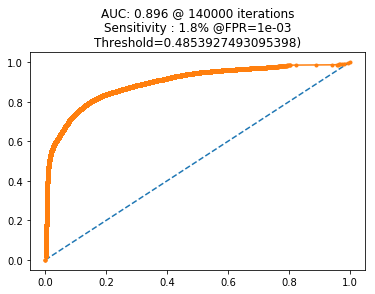

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:111: MatplotlibDeprecationWarning: numpy.hypot


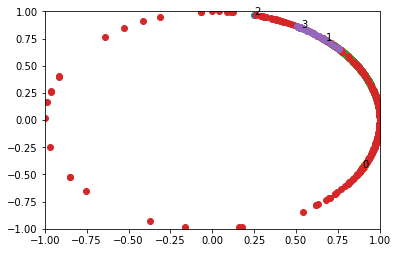

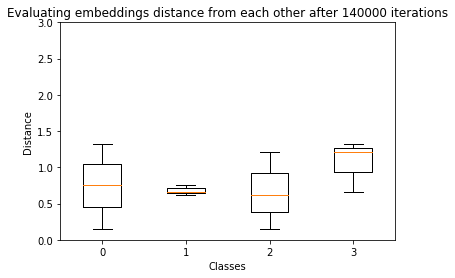

In [35]:
#Full evaluation
draw_eval3i(network3i,metric_network3i,n_iteration)

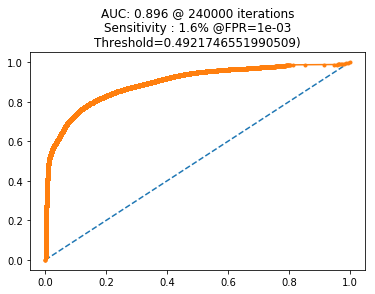

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:111: MatplotlibDeprecationWarning: numpy.hypot


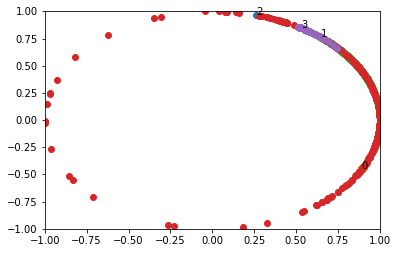

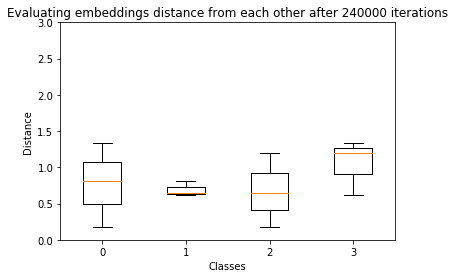

In [38]:
#Full evaluation
draw_eval3i(network3i,metric_network3i,n_iteration)